In [ ]:
# Updated: June 2021, included BAT Space Partitioning 

In [1]:
using Distributions 
using IntervalSets
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Random123
using HCubature
using HDF5

# using KDTree
using BAT
# # using BATPar

using LaTeXStrings

In [40]:
import PyPlot

plt = PyPlot

SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 9

plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("text", usetex=false)

colors = vcat([0 0 0 0], plt.cm.YlOrRd(range(0, stop=1, length=10))[2:end,:]);
# colors = vcat([0 0 0 0.1], plt.cm.Blues(range(0, stop=1, length=10))[3:end,:])

figsize = (4.667538397675384, 2.8846973735586108)

(4.667538397675384, 2.8846973735586108)

In [ ]:
# prior = NamedTupleDist(a = [[1.0 .. 2.0 for i in 1:2]...],);
# outp = bat_read("../../MCMC_publication/Saved_samples/samples_2.hdf5")
# samples = varshape(prior).(outp);

In [3]:
g(x;) = 0.8*pdf.(Normal(-5,0.9), x)+1.2*pdf.(Normal(-1.0,0.4), x) + 0.8*pdf.(Normal(1.0,0.4), x) + 0.8*pdf.(Normal(5,0.9), x) # 2

likelihood = params -> LogDVal((log(g(params.a))))
prior = NamedTupleDist(a = -10. .. 10.);
posterior = PosteriorDensity(likelihood, prior);

samples = bat_sample(posterior, MCMCSampling(nsteps=1000, nchains=10)).result;

┌ Info: Initializing new RNG of type Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 10 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 10 tuned, 10 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_bur

In [4]:
Data(x, y, z) = (samples = x, weights = y, loglik=z)

Data (generic function with 1 method)

In [5]:
smpl = flatview(unshaped.(samples.v))
weights_LogLik = samples.logd
weights_Histogram = samples.weight;

data_kdtree = (samples = smpl[:,1:5:end], weights = weights_Histogram[1:5:end], loglik=weights_LogLik[1:5:end]);

In [6]:
cost_1 = BAT.evaluate_total_cost(data_kdtree)
output_1 = BAT.find_min_along_axis(data_kdtree, 1)

(-8.057909438125764:0.3242208414537877:7.828911793109835, [Inf, Inf, Inf, Inf, 1.2884200774707021e7, 1.2600272320839774e7, 1.149867047957975e7, 1.0944384980229575e7, 9.578042876151778e6, 8.840037769890925e6  …  7.372196400430331e6, 8.865951983927403e6, 9.872319276533999e6, 1.1259235976767004e7, 1.2176572840313181e7, 1.2821884835437367e7, Inf, Inf, Inf, Inf], 0.0476115982189297, 2.1028793634896968e6)

In [7]:
data_kdtree_2 = Data(collect(transpose(data_kdtree.samples[data_kdtree.samples[1,:] .> output_1[3]])), data_kdtree.weights[data_kdtree.samples[1,:] .> output_1[3]], data_kdtree.loglik[data_kdtree.samples[1,:] .> output_1[3]]);
data_kdtree_3 = Data(collect(transpose(data_kdtree.samples[data_kdtree.samples[1,:] .< output_1[3]])), data_kdtree.weights[data_kdtree.samples[1,:] .< output_1[3]], data_kdtree.loglik[data_kdtree.samples[1,:] .< output_1[3]]);

In [8]:
cost_2 = BAT.evaluate_total_cost(data_kdtree_2)
cost_3 = BAT.evaluate_total_cost(data_kdtree_3)

output_2 = BAT.find_min_along_axis(data_kdtree_2, 1)
output_3 = BAT.find_min_along_axis(data_kdtree_3, 1)

(-8.057909438125764:0.1626423119417241:-0.08843615298128249, [Inf, Inf, Inf, Inf, Inf, Inf, Inf, 1.1581529387999682e6, 1.1581529387999682e6, 1.1034875197281784e6  …  175385.81603616956, 276343.4689075601, 399511.2614254966, 530833.7944466098, 633672.7387534461, 704693.1533401051, 858556.5028959928, 1.0733934148289775e6, 1.193156783768216e6, Inf], -2.8533554559905925, 89726.32830764819)

In [9]:
data_kdtree_4 = Data(collect(transpose(data_kdtree_3.samples[data_kdtree_3.samples[1,:] .> output_3[3]])), data_kdtree_3.weights[data_kdtree_3.samples[1,:] .> output_3[3]], data_kdtree_3.loglik[data_kdtree_3.samples[1,:] .> output_3[3]]);
data_kdtree_5 = Data(collect(transpose(data_kdtree_3.samples[data_kdtree_3.samples[1,:] .< output_3[3]])), data_kdtree_3.weights[data_kdtree_3.samples[1,:] .< output_3[3]], data_kdtree_3.loglik[data_kdtree_3.samples[1,:] .< output_3[3]]);

In [10]:
cost_4 = BAT.evaluate_total_cost(data_kdtree_4)
cost_5 = BAT.evaluate_total_cost(data_kdtree_5)

output_4 = BAT.find_min_along_axis(data_kdtree_4, 1)
output_5 = BAT.find_min_along_axis(data_kdtree_5, 1)

(-8.057909438125764:0.10598859758169106:-2.8644681566229018, [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf  …  36306.51211516529, 42227.94499723143, 44702.291960199116, 49879.86717775006, 53554.4453715242, 56192.80042315523, 60773.14276179534, 60773.14276179534, Inf, Inf], -4.878251510675032, 11916.580296970282)

In [11]:
cost_array = [cost_1, output_1[4], output_3[4]+cost_2, output_2[4]+cost_5+cost_4]
cut_range = 0:1:3

0:1:3

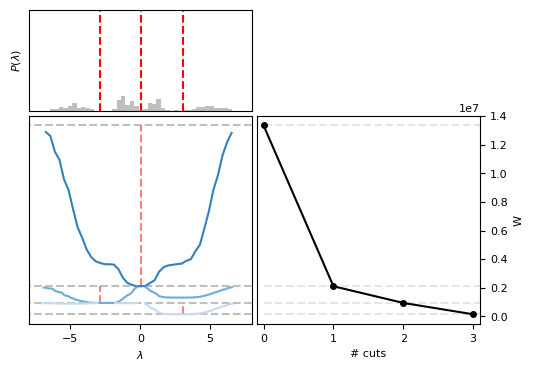

(0.0, 1300.0)

In [12]:
fig = plt.figure(figsize=(5.826767123287671, 4.07873698630137),)

fig.subplots_adjust(hspace=0.05, wspace=0.02)

ax1 = plt.subplot2grid((3, 2), (1, 0), rowspan=2, colspan=1, yticklabels=[],  yticks=[], )
ax2 = plt.subplot2grid((3, 2), (0, 0), rowspan=1, colspan=1, xticklabels=[], yticklabels=[], xticks=[], yticks=[], )
# ax3 = plt.subplot2grid((3, 2), (1, 1), rowspan=3, colspan=1, xticklabels=[], yticklabels=[], xticks=[], yticks=[], fc="orange",)
ax3 = plt.subplot2grid((3, 2), (1, 1), rowspan=3, colspan=1,  )

ax2.hist(data_kdtree.samples[1,:], weights=data_kdtree.weights, bins=50, color="gray", alpha=0.5, label="Density");
ax2.vlines(output_1[3], 0, 1700, color="red", ls="--", label="Cut position")
ax2.vlines(output_3[3], 0, 1700, color="red", ls="--")
ax2.vlines(output_2[3], 0, 1700, color="red", ls="--")
ax2.get_xaxis().set_visible(false) 
# ax2.legend(loc="upper left", frameon=true, framealpha=0.9, ncol=1)
ax2.set_ylabel(L"P(\lambda)")

# ax1.plot(output_1[1], output_1[2], color="steelblue") #dodgerblue skyblue lightskyblue lightblue
# ax1.plot(output_2[1], cost_3 .+ output_2[2], color="lightskyblue")
# ax1.plot(output_3[1], cost_2 .+ output_3[2], color="lightskyblue")
# ax1.plot(output_4[1],  cost_2 + cost_5 .+ output_4[2], color="lightblue")
# ax1.plot(output_5[1], cost_2 + cost_4 .+ output_5[2], color="lightblue")
# ax1.plot(output_2[1], cost_5+cost_4 .+ output_2[2], color="lightblue")

ax1.plot(output_1[1], output_1[2], color=PyPlot.ColorMap("tab20c").colors[1]) #dodgerblue skyblue lightskyblue lightblue
ax1.plot(output_2[1], cost_3 .+ output_2[2], color=PyPlot.ColorMap("tab20c").colors[2])
ax1.plot(output_3[1], cost_2 .+ output_3[2], color=PyPlot.ColorMap("tab20c").colors[2])
ax1.plot(output_4[1],  cost_2 + cost_5 .+ output_4[2], color=PyPlot.ColorMap("tab20c").colors[4])
ax1.plot(output_5[1], cost_2 + cost_4 .+ output_5[2], color=PyPlot.ColorMap("tab20c").colors[4])
ax1.plot(output_2[1], cost_5+cost_4 .+ output_2[2], color=PyPlot.ColorMap("tab20c").colors[4])

ax1.hlines(output_3[4]+cost_2, -10,10, color="gray", ls="--", alpha=0.5)
ax1.hlines(output_2[4]+cost_5+cost_4, -10,10, color="gray", ls="--", alpha=0.5)
ax1.hlines(cost_1, -10,10, color="gray", ls="--", alpha=0.5 )
ax1.hlines(output_1[4], -10,10, color="gray", ls="--", alpha=0.5)

ax1.vlines(output_1[3], output_1[4], cost_1, color="red", alpha=0.5, ls="--")
ax1.vlines(output_3[3], output_3[4]+cost_2, output_1[4], color="red", alpha=0.5, ls="--")
ax1.vlines(output_2[3], output_2[4]+cost_5+cost_4, output_3[4]+cost_2, color="red", alpha=0.5, ls="--")
# ax2.vlines(output_3[3], 0, 700, color="red")
# ax2.vlines(output_2[3], 0, 700, color="red")

ax1.set_xlabel(L"\lambda")

ax3.plot(collect(cut_range), cost_array, color="black", "-o", ms=4, mfc="k")
ax3.yaxis.tick_right()
ax3.yaxis.set_ticks_position("right")
ax3.set_xlabel("# cuts")
ax3.set_ylabel("W")
ax3.yaxis.set_label_position("right")

ax3.hlines(output_3[4]+cost_2, 0,4, color="gray", ls="--", alpha=0.2)
ax3.hlines(output_2[4]+cost_5+cost_4, 0,4, color="gray", ls="--", alpha=0.2)
ax3.hlines(cost_1, 0,4, color="gray", ls="--", alpha=0.2)
ax3.hlines(output_1[4], 0,4, color="gray", ls="--", alpha=0.2)
ax3.set_xticks(collect(cut_range))
ax3.set_xlim(-0.1, 3.1)

ax2.set_xlim(-8., 8.)
ax1.set_xlim(-8., 8.)

ax2.set_ylim(0.0, 1300.)

# fig.savefig("../plots/fig-b.pdf", bbox_inches = "tight")

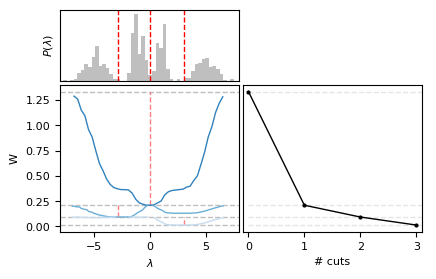

In [42]:
fig = plt.figure(figsize=figsize)

fig.subplots_adjust(hspace=0.05, wspace=0.02)

ax1 = plt.subplot2grid((3, 2), (1, 0), rowspan=2, colspan=1, )
ax2 = plt.subplot2grid((3, 2), (0, 0), rowspan=1, colspan=1, xticklabels=[], yticklabels=[], xticks=[], yticks=[], )
# ax3 = plt.subplot2grid((3, 2), (1, 1), rowspan=3, colspan=1, xticklabels=[], yticklabels=[], xticks=[], yticks=[], fc="orange",)
ax3 = plt.subplot2grid((3, 2), (1, 1), rowspan=3, colspan=1,  yticklabels=[], yticks=[],)

ax2.hist(data_kdtree.samples[1,:], weights=data_kdtree.weights, bins=50, color="gray", alpha=0.5, label="Density");
ax2.vlines(output_1[3], 0, 1700, color="red", lw=1., ls="--", label="Cut position")
ax2.vlines(output_3[3], 0, 1700, color="red", lw=1., ls="--")
ax2.vlines(output_2[3], 0, 1700, color="red", lw=1., ls="--")
ax2.get_xaxis().set_visible(false) 
# ax2.legend(loc="upper left", frameon=true, framealpha=0.9, ncol=1)
ax2.set_ylabel(L"P(\lambda)")

# ax1.plot(output_1[1], output_1[2], color="steelblue") #dodgerblue skyblue lightskyblue lightblue
# ax1.plot(output_2[1], cost_3 .+ output_2[2], color="lightskyblue")
# ax1.plot(output_3[1], cost_2 .+ output_3[2], color="lightskyblue")
# ax1.plot(output_4[1],  cost_2 + cost_5 .+ output_4[2], color="lightblue")
# ax1.plot(output_5[1], cost_2 + cost_4 .+ output_5[2], color="lightblue")
# ax1.plot(output_2[1], cost_5+cost_4 .+ output_2[2], color="lightblue")

ax1.plot(output_1[1], output_1[2], lw=1., color=PyPlot.ColorMap("tab20c").colors[1]) #dodgerblue skyblue lightskyblue lightblue
ax1.plot(output_2[1], cost_3 .+ output_2[2], lw=1.,color=PyPlot.ColorMap("tab20c").colors[2])
ax1.plot(output_3[1], cost_2 .+ output_3[2], lw=1.,color=PyPlot.ColorMap("tab20c").colors[2])
ax1.plot(output_4[1],  cost_2 + cost_5 .+ output_4[2], lw=1.,color=PyPlot.ColorMap("tab20c").colors[4])
ax1.plot(output_5[1], cost_2 + cost_4 .+ output_5[2], lw=1.,color=PyPlot.ColorMap("tab20c").colors[4])
ax1.plot(output_2[1], cost_5+cost_4 .+ output_2[2], lw=1., color=PyPlot.ColorMap("tab20c").colors[4])

ax1.hlines(output_3[4]+cost_2, -10,10, lw=1., color="gray", ls="--", alpha=0.5)
ax1.hlines(output_2[4]+cost_5+cost_4, -10,10, lw=1.,color="gray", ls="--", alpha=0.5)
ax1.hlines(cost_1, -10,10, color="gray", lw=1., ls="--", alpha=0.5 )
ax1.hlines(output_1[4], -10,10, color="gray", lw=1., ls="--", alpha=0.5)

ax1.vlines(output_1[3], output_1[4], cost_1, color="red", lw=1., alpha=0.5, ls="--")
ax1.vlines(output_3[3], output_3[4]+cost_2, output_1[4], color="red", lw=1., alpha=0.5, ls="--")
ax1.vlines(output_2[3], output_2[4]+cost_5+cost_4, output_3[4]+cost_2, lw=1., color="red", alpha=0.5, ls="--")
# ax2.vlines(output_3[3], 0, 700, color="red")
# ax2.vlines(output_2[3], 0, 700, color="red")

ax1.set_xlabel(L"\lambda")

ax3.plot(collect(cut_range), cost_array, color="black", "-o", lw=1., ms=2, mfc="k")
ax3.yaxis.tick_right()
ax3.yaxis.set_ticks_position("right")
ax3.set_xlabel("# cuts")
ax1.set_ylabel("W")
# ax3.yaxis.set_label_position("right")

ax3.hlines(output_3[4]+cost_2, 0,4, color="gray", lw=1., ls="--", alpha=0.2)
ax3.hlines(output_2[4]+cost_5+cost_4, 0,4, color="gray", lw=1., ls="--", alpha=0.2)
ax3.hlines(cost_1, 0,4, color="gray", ls="--", lw=1., alpha=0.2)
ax3.hlines(output_1[4], 0,4, color="gray", ls="--", lw=1., alpha=0.2)
ax3.set_xticks(collect(cut_range))
ax3.set_xlim(-0.1, 3.1)

ax2.set_xlim(-8., 8.)
ax1.set_xlim(-8., 8.)

ax2.set_ylim(0,200)

# fig.savefig("../plots/fig-b.pdf", bbox_inches = "tight")